<a href="https://colab.research.google.com/github/Prakadeeswaran05/VAE_Pytorch/blob/main/VAE_from_scratch_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imports
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
#Download the dataset
!mkdir data
%cd /content/data/
!mkdir celeba
%cd /content/data/celeba/
!wget https://graal.ift.ulaval.ca/public/celeba/img_align_celeba.zip
!wget https://graal.ift.ulaval.ca/public/celeba/list_attr_celeba.txt
!wget https://graal.ift.ulaval.ca/public/celeba/identity_CelebA.txt
!wget https://graal.ift.ulaval.ca/public/celeba/list_bbox_celeba.txt
!wget https://graal.ift.ulaval.ca/public/celeba/list_landmarks_align_celeba.txt
!wget https://graal.ift.ulaval.ca/public/celeba/list_eval_partition.txt
!unzip img_align_celeba.zip 

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

In [3]:
#Loading the dataset
batch_size=256
download=True
num_workers=0
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
   
    
])
test_transforms=torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
   
    
])
train_dataset = datasets.CelebA(root='/content/data',
                                    split='train',
                                    transform=train_transforms,
                                    download=False)

valid_dataset = datasets.CelebA(root='/content/data',
                                split='valid',
                                transform=test_transforms)

test_dataset = datasets.CelebA(root='/content/data',
                                split='test',
                                transform=test_transforms)
 

   


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          shuffle=True)

valid_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          shuffle=False)

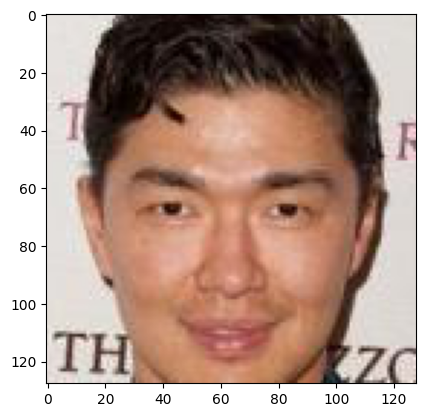

In [369]:
# Let's visualize an image from train dataset
import numpy as np
images, labels = next(iter(train_loader))
example_img=images[1].unsqueeze(0).to('cuda')

images = np.transpose(images, (0, 2, 3, 1))

plt.imshow(images[1].squeeze(), cmap='gray')
plt.show()

In [13]:
#VAE model
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.15),
                
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.15),
                
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.15),
                
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.15),
                
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(4096, 200)
        self.z_log_var = torch.nn.Linear(4096, 200)
    def forward(self,x):
        x = self.encoder(x)
  
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
       
        eps = torch.randn(z_mean.size(0), z_mean.size(1)).to('cuda')
        encoder_out = z_mean + eps * torch.exp(z_log_var/2.) 
        return encoder_out,z_mean,z_log_var


class Decoder(nn.Module):
  def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(200, 4096)
        self.layer1= nn.Sequential(nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.15))
        
        self.layer2=nn.Sequential( nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.15))
        
        self.layer3=nn.Sequential(nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.15),
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1))
        
        self.sigmoid=nn.Sigmoid()

  def forward(self,x):
    x=self.linear1(x)
    x=x.view((-1, 64, 8, 8))
    x=self.layer1(x)
    x=self.layer2(x)
    x=self.layer3(x)
    x=x[:, :, :128, :128]
    decoder_out=self.sigmoid(x)
    return decoder_out

class VAE(nn.Module):
  def __init__(self):
        super().__init__()
        self.encoder=Encoder()
        self.decoder=Decoder()

  def forward(self,x):
    encoder_out,z_mean,z_log_var=self.encoder(x)
    decoder_out=self.decoder(encoder_out)
    return encoder_out,z_mean,z_log_var,decoder_out
        

In [14]:
#setting the hyperparameters
from torch.optim.lr_scheduler import StepLR
model = VAE()
DEVICE=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
LEARNING_RATE = 0.0008
model.to(DEVICE)


optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,betas=(0.5,0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) 
# # Define the learning rate schedule
# lr_decay_factor = 0.001  # The factor by which to decay the learning rate
# lr_decay_step = 10  # The number of epochs after which to decay the learning rate
# scheduler = StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_factor)


In [ ]:
#Training Variational Autoencoder
import time
import torch
import torch.nn.functional as F


def train_vae(num_epochs, model, optimizer, device, train_loader, reconstruction_weight=1, logging_interval=100, save_model=None):

    log_dict = {'train_loss_batch': [], 'train_loss_epoch': []}

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        num_examples = 0

        for batch_idx, (features, _) in enumerate(train_loader):
            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)
          
            kl_div = -0.5 * torch.sum(1 + z_log_var - z_mean ** 2 - torch.exp(z_log_var), dim=1)
            kl_div = kl_div.mean()

            pixelwise = F.mse_loss(decoded, features, reduction='none')
            pixelwise = pixelwise.view(pixelwise.size(0), -1).sum(dim=1)
            pixelwise = pixelwise.mean()

            loss = reconstruction_weight * pixelwise + kl_div
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            log_dict['train_loss_batch'].append(loss.item())

            epoch_loss += loss.item() * features.size(0)
            num_examples += features.size(0)

            if not (batch_idx + 1) % logging_interval:
                print(f'Epoch: {epoch + 1}/{num_epochs} | Batch {batch_idx + 1}/{len(train_loader)} | Loss: {loss:.4f}')

        epoch_loss /= num_examples
        log_dict['train_loss_epoch'].append(epoch_loss)

        print(f'***Epoch: {epoch + 1}/{num_epochs} | Loss: {epoch_loss:.3f} | Time elapsed: {(time.time() - start_time) / 60:.2f} min')

    print(f'Total Training Time: {(time.time() - start_time) / 60:.2f} min')

    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict

In [ ]:
BATCH_SIZE = 256
NUM_EPOCHS = 50

log_dict = train_vae(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                       
                        save_model='vae.pt')

Epoch: 1/50 | Batch 100/636 | Loss: 1208.2456
Epoch: 1/50 | Batch 200/636 | Loss: 1007.6116
Epoch: 1/50 | Batch 300/636 | Loss: 922.7459
Epoch: 1/50 | Batch 400/636 | Loss: 875.4803
Epoch: 1/50 | Batch 500/636 | Loss: 832.0098
Epoch: 1/50 | Batch 600/636 | Loss: 762.9787
***Epoch: 1/50 | Loss: 1105.630 | Time elapsed: 3.14 min
Epoch: 2/50 | Batch 100/636 | Loss: 789.9233
Epoch: 2/50 | Batch 200/636 | Loss: 777.8820
Epoch: 2/50 | Batch 300/636 | Loss: 759.2855
Epoch: 2/50 | Batch 400/636 | Loss: 689.6860
Epoch: 2/50 | Batch 500/636 | Loss: 723.8438
Epoch: 2/50 | Batch 600/636 | Loss: 685.9897
***Epoch: 2/50 | Loss: 728.976 | Time elapsed: 6.24 min
Epoch: 3/50 | Batch 100/636 | Loss: 712.5795
Epoch: 3/50 | Batch 200/636 | Loss: 683.1119
Epoch: 3/50 | Batch 300/636 | Loss: 653.5131
Epoch: 3/50 | Batch 400/636 | Loss: 669.3160
Epoch: 3/50 | Batch 500/636 | Loss: 638.5996
Epoch: 3/50 | Batch 600/636 | Loss: 694.0048
***Epoch: 3/50 | Loss: 668.322 | Time elapsed: 9.34 min
Epoch: 4/50 | Batch

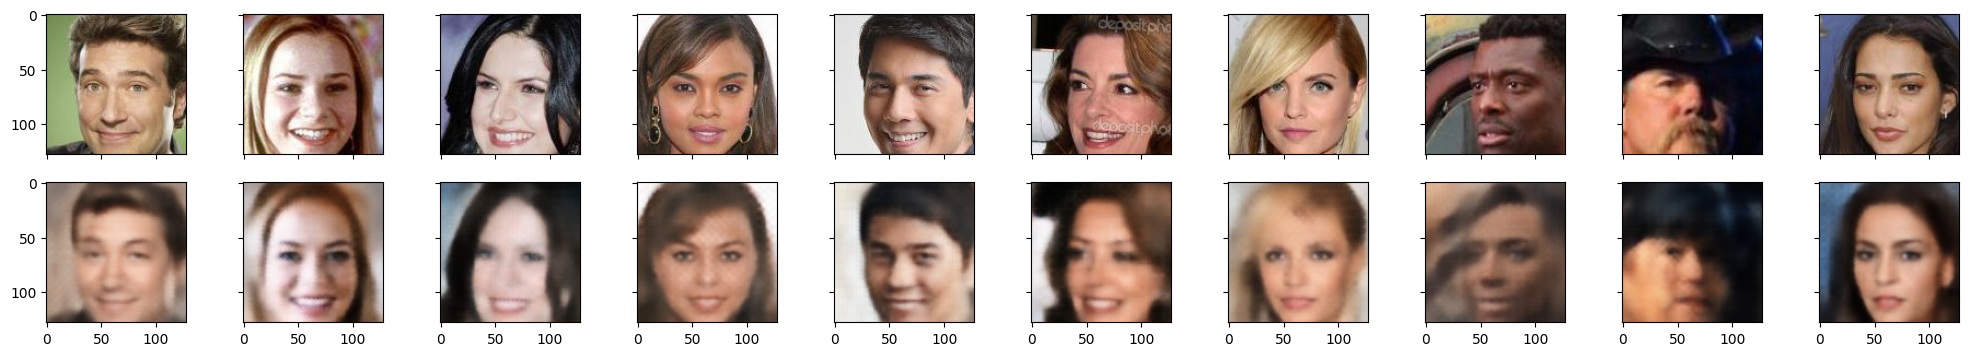

In [20]:
# Reconstructinf the images and displaying it
def plot_reconstructed_images(data_loader, model, device, figsize=(25, 4), n_images=10):
    fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):
        features = features.to(device)
        with torch.no_grad():
            encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
        break

    for i in  range(n_images):
        original_image = features[i].detach().to(torch.device('cpu'))
        reconstructed_image = decoded_images[i].detach().to(torch.device('cpu'))

        if original_image.shape[0] > 1:
            original_image = original_image.permute(1, 2, 0)
            reconstructed_image = reconstructed_image.permute(1, 2, 0)
        
        axes[0][i].imshow(original_image)
        axes[1][i].imshow(reconstructed_image)
        
    plt.show()
plot_reconstructed_images(data_loader=train_loader,
                      model=model,
                      device=DEVICE,
                      )           


In [15]:
#Load the saved model
model = VAE()
model.load_state_dict(torch.load('/content/vae.pt', map_location=torch.device('cpu')))
model.to('cuda');


In [389]:
def compute_average_embeddings_by_feature(feature_index, image_size, data_loader, device=None, encoder=None):

    sum_embeddings_with_feature = torch.zeros(image_size, dtype=torch.float32)
    sum_embeddings_without_feature = torch.zeros(image_size, dtype=torch.float32)

    num_images_with_feature = 0
    num_images_without_feature = 0

    for images, labels in data_loader:
        mask_with_feature = labels[:, feature_index].to(torch.bool)

        if encoder is not None:
            with torch.no_grad():
                if device is not None:
                    images = images.to(device)
                embeddings,_,_ = encoder(images)
                embeddings=embeddings.to('cpu')
        else:
            embeddings = images

        sum_embeddings_with_feature += torch.sum(embeddings[mask_with_feature], axis=0)
        sum_embeddings_without_feature += torch.sum(embeddings[~mask_with_feature], axis=0)
        num_images_with_feature += mask_with_feature.sum(axis=0)
        num_images_without_feature += (~mask_with_feature).sum(axis=0)

    avg_embeddings_with_feature = sum_embeddings_with_feature / num_images_with_feature
    avg_embeddings_without_feature = sum_embeddings_without_feature / num_images_without_feature
    
    return avg_embeddings_with_feature, avg_embeddings_without_feature


def plot_scaled_embeddings(original, diff,
                        diff_coefficients=(0., 1., 1.5, 2, 2.5),
                        decoder=None,
                        device=None,
                        figsize=(9, 3)):
  
    if device is not None:
        original = original.to(device)
        diff = diff.to(device)
        diff_coefficients = torch.tensor(diff_coefficients, device=device)
    else:
        diff_coefficients = torch.tensor(diff_coefficients)

    with torch.no_grad():
        if device is not None:
            diff_coefficients = torch.tensor(diff_coefficients, device=device)
        else:
            diff_coefficients = torch.tensor(diff_coefficients)

        fig, axes = plt.subplots(nrows=1, ncols=len(diff_coefficients), 
                                 sharex=True, sharey=True, figsize=figsize)

        for i, alpha in enumerate(diff_coefficients):
            more = original + alpha*diff
           

            title = 'original' if alpha == 0 else f'dif_coeff=${alpha}'

            if decoder is not None:
                with torch.no_grad():
                    more=more.unsqueeze(0)
                   
                    if device is not None:
                        more = more.to(device)

                    decoded = decoder(more).to('cpu')

                   
                    more = decoded.squeeze(0)
                   
            axes[i].set_title(title)
            axes[i].imshow(more.permute(1, 2, 0))
            axes[i].axison = False



In [390]:
avg_embeddings_with_feature, avg_embeddings_without_feature = compute_average_embeddings_by_feature(
    feature_index=31, #smile feature
    image_size=200,
    data_loader=train_loader,
    device='cuda',
    encoder=model.encoder)



diff = (avg_embeddings_with_feature -  avg_embeddings_without_feature)






<ipython-input-389-d453de770e51>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff_coefficients = torch.tensor(diff_coefficients, device=device)


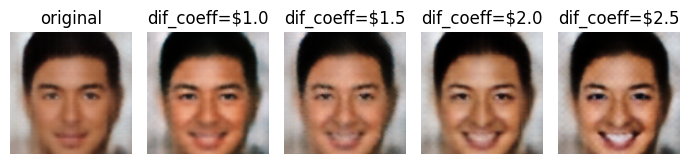

In [391]:
with torch.no_grad():
    encoded,_,_ = model.encoder(example_img)
    encoded=encoded.squeeze(0).to('cpu')

plot_scaled_embeddings(original=encoded,
                    diff=diff,
                    device='cuda',
                   
                    decoder=model.decoder,
                    figsize=(7, 2.5))

plt.tight_layout()
plt.show()

<ipython-input-389-d453de770e51>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff_coefficients = torch.tensor(diff_coefficients, device=device)


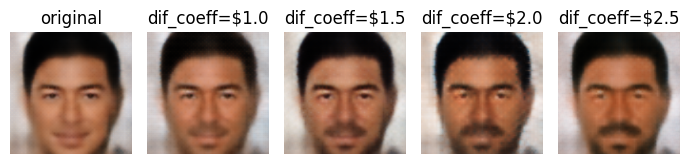

In [392]:
avg_embeddings_with_feature, avg_embeddings_without_feature = compute_average_embeddings_by_feature(
    feature_index=16, #beard
    image_size=200,
    data_loader=train_loader,
    device='cuda',
    encoder=model.encoder)



diff = (avg_embeddings_with_feature -  avg_embeddings_without_feature)



plot_scaled_embeddings(original=encoded,
                    diff=diff,
                    device='cuda',
                   
                    decoder=model.decoder,
                    figsize=(7, 2.5))

plt.tight_layout()
plt.show()





<ipython-input-389-d453de770e51>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff_coefficients = torch.tensor(diff_coefficients, device=device)


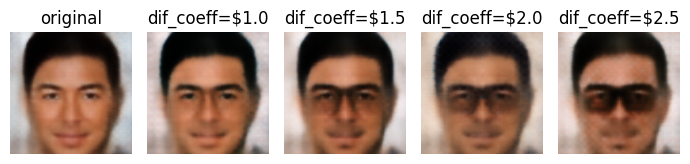

In [393]:
avg_embeddings_with_feature, avg_embeddings_without_feature = compute_average_embeddings_by_feature(
    feature_index=15, #glasses
    image_size=200,
    data_loader=train_loader,
    device='cuda',
    encoder=model.encoder)



diff = (avg_embeddings_with_feature -  avg_embeddings_without_feature)


plot_scaled_embeddings(original=encoded,
                    diff=diff,
                    device='cuda',
                   
                    decoder=model.decoder,
                    figsize=(7, 2.5))

plt.tight_layout()
plt.show()
